### Imports

In [1]:
import os
import pickle
from collections import defaultdict

import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

%matplotlib inline

### Constants

In [2]:
NUM_CLASSES = 7178
IMAGE_DIR = r'X:\OpenImages\images\train_320'

### Label map

In [3]:
classes_path = r'X:\OpenImages\InclusiveChallenge\docs\class-descriptions_trainable.csv'
content = [l.strip().split(',') for l in open(classes_path, encoding='utf8').readlines()]
class_id_to_desc = {content[i][0]: content[i][1] for i in range(len(content))}

### Train labels correlation

In [4]:
def get_key(l1, l2):
    return '-'.join(sorted([l1, l2]))

In [5]:
content = [l.strip().split() for l in open(r'X:\OpenImages\InclusiveChallenge\lists\all_train_multi.txt')]

In [14]:
correlations = defaultdict(int)
correlations_images = defaultdict(list)
class_id_to_correlations = defaultdict(set)
class_id_to_num_instances = defaultdict(int)
for line in tqdm(content):
    labels = line[1:]
    for label in labels:
        class_id_to_num_instances[label] += 1
    for i in range(len(labels)):
        for j in range(i + 1, len(labels)):
            key = get_key(labels[i], labels[j])
            correlations[key] += 1
            correlations_images[key] += [line[0]]
            class_id_to_correlations[labels[i]].add(key)
            class_id_to_correlations[labels[j]].add(key)

100%|██████████| 1736975/1736975 [00:34<00:00, 50052.87it/s]


In [15]:
# normalized correlations between 0-1
normalized_correlations = {}
for key, count in correlations.items():
    label_1 = key.split('-')[0]
    label_2 = key.split('-')[1]
    norm_1 = count / class_id_to_num_instances[label_1]
    norm_2 = count / class_id_to_num_instances[label_2]
    normalized_correlations[key] = (norm_1, norm_2)

In [7]:
print('number of correlations: {}'.format(len(correlations)))

number of correlations: 1028619


In [8]:
sorted_correlations = sorted(correlations.items(), key=lambda a: a[1], reverse=True)

In [9]:
print('Top 10 correlations:')
print(sorted_correlations[:10])

Top 10 correlations:
[('/m/01g317-/m/09j2d', 582162), ('/m/01g317-/m/0dzct', 320593), ('/m/09j2d-/m/0dzct', 261637), ('/m/01prls-/m/07yv9', 159474), ('/m/05s2s-/m/07j7r', 148662), ('/m/01g317-/m/09j5n', 125415), ('/m/09j2d-/m/09j5n', 117082), ('/m/07yv9-/m/0k4j', 98252), ('/m/01prls-/m/0k4j', 93844), ('/m/01g317-/m/07j7r', 81717)]


In [28]:
correlation_index = 5
correlation_key = sorted_correlations[correlation_index][0]
correlation_count = sorted_correlations[correlation_index][1]
name_1 = class_id_to_desc[correlation_key.split('-')[0]]
name_2 = class_id_to_desc[correlation_key.split('-')[1]]
print('Correlation labels: {} and {}. Count = {}'.format(name_1, name_2, correlation_count))

Correlation labels: Person and Footwear. Count = 125415


In [29]:
print('normalized correlations: {} {}'.format(normalized_correlations[correlation_key][0], normalized_correlations[correlation_key][1]))

normalized correlations: 0.15584633450763294 0.9354651032692609


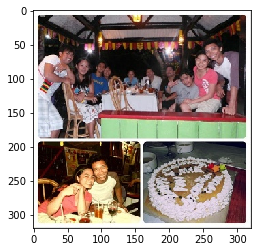

In [19]:
image_path = os.path.join(IMAGE_DIR, correlations_images[correlation_key][0]) + '.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [94]:
with open(r'X:\OpenImages\InclusiveChallenge\train_labels_correlations.pkl', 'wb') as f:
        pickle.dump(correlations, f, pickle.HIGHEST_PROTOCOL)

In [95]:
with open(r'X:\OpenImages\InclusiveChallenge\train_correlation_images.pkl', 'wb') as f:
        pickle.dump(correlations_images, f, pickle.HIGHEST_PROTOCOL)

# Enhance predictions

In [41]:
base_predictions_path = r'D:\temp\inclusive\all-1319557_60.txt'
base_predictions = [l.strip().split(',') for l in open(base_predictions_path)][1:]
new_predictions = {}
added_labels = 0
for line in tqdm(base_predictions):
    image_id = line[0]
    labels = set(line[1].split())
    new_labels = set()
    for label in labels:
        new_labels.add(label)
        if class_id_to_num_instances[label] < 100:
            continue
        label_correlations = class_id_to_correlations[label]
        for correlation_key in label_correlations:
            split_key = correlation_key.split('-')
            normalized_index = 0 if label == split_key[0] else 1
            corr_normalized = normalized_correlations[correlation_key][normalized_index]
            if corr_normalized > 0.7:
                #print('image id {}: adding correlation: {} {}'.format(image_id, correlation_key, corr_normalized))
                new_labels.add(split_key[0])
                new_labels.add(split_key[1])
    new_predictions[image_id] = new_labels
    added_labels += (len(new_labels) - len(labels))
with open(r'D:\temp\inclusive\all-1319557_60_enhanced.txt', 'w') as f:
    f.write('image_id,labels\n')
    for image_id, labels in new_predictions.items():
        f.write('{},{}\n'.format(image_id, ' '.join(list(labels))))


100%|██████████| 5000/5000 [00:41<00:00, 119.72it/s]


In [42]:
added_labels

754